#  Track Analysis

In order to properly analyze our GPX tracks, we need to put all of them into the same _frame-of-reference_.   This is accomplished by creating a single route, then comparing all routes against that.

## Step 0: Globals

In [1]:
database_path = 'bike_data.db'

start_coord = (39.5989743, -104.8609468)
end_coord   = (39.75428108249532, -105.00085402872664)

epsg_code = 32613

## Step 1: Import Required Libraries

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from pyproj import CRS, Proj, Transformer
import re, numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib as mpl
from matplotlib import cm
import os, shutil
from dataclasses import dataclass
import ipywidgets as widgets
from functools import partial

### Step 2: Setup the database.

In [3]:
# SQLAlchemy connectable 
conn = create_engine( 'sqlite:///' + database_path ).connect()

#  For each segment, we need to create a track for each dataset
dataset_ids = pd.read_sql_query('SELECT DISTINCT datasetId FROM point_list', conn)

#  Load the Vertex List
vtx_list = pd.read_csv('waypoints.csv')
display(vtx_list)

SectorId  NumWaypoints  Iteration       Fitness  GridZone  \
0       sector_0             8          0  2.413054e+07        13   
1       sector_0             8          0  2.413054e+07        13   
2       sector_0             8          0  2.413054e+07        13   
3       sector_0             8          0  2.413054e+07        13   
4       sector_0             8          0  2.413054e+07        13   
...          ...           ...        ...           ...       ...   
148109  sector_8            13        244  1.560376e+07        13   
148110  sector_8            13        244  1.560376e+07        13   
148111  sector_8            13        244  1.560376e+07        13   
148112  sector_8            13        244  1.560376e+07        13   
148113  sector_8            13        244  1.560376e+07        13   

              Easting      Northing   Latitude   Longitude  \
0       511949.837255  4.383253e+06  39.598926 -104.860817   
1       511940.000000  4.383209e+06  39.598532 -104.860932   
2       511442.000000  4.383208e+06  39.598530 -104.866733   
3       511448.000000  4.383821e+06  39.604053 -104.866652   
4       511451.000000  4.383888e+06  39.604657 -104.866616   
...               ...           ...        ...         ...   
148109  499802.000000  4.400224e+06  39.751926 -105.002311   
148110  499778.000000  4.400354e+06  39.753097 -105.002591   
148111  499792.000000  4.400404e+06  39.753548 -105.002428   
148112  499962.000000  4.400546e+06  39.754827 -105.000444   
148113  499995.267057  4.400552e+06  39.754884 -105.000055   

                                                      DNA  
0       6760016178001518406281870695197262918328190402...  
1       6760016178001518406281870695197262918328190402...  
2       6760016178001518406281870695197262918328190402...  
3       6760016178001518406281870695197262918328190402...  
4       6760016178001518406281870695197262918328190402...  
...                                                   ...  
148109  4890043399016432404003080719249088418309780441...  
148110  4890043399016432404003080719249088418309780441...  
148111  4890043399016432404003080719249088418309780441...  
148112  4890043399016432404003080719249088418309780441...  
148113  4890043399016432404003080719249088418309780441...  

[148114 rows x 10 columns]

### Step 3: Setup UTM Coordinate Projection API

In [4]:
#  Setup the Projection Transformer
crs = CRS.from_epsg( epsg_code )
proj_dd2utm = Transformer.from_crs(crs.geodetic_crs, crs)
proj_utm2dd = Transformer.from_crs(crs, crs.geodetic_crs)
utm_zone = int(re.findall("\d+", crs.utm_zone)[0])
print('UTM Grid Zone: {}'.format(utm_zone))

(easting,northing) = proj_dd2utm.transform( start_coord[0], start_coord[1] )
start_coord_utm = np.array( [easting, northing], np.float64 )

UTM Grid Zone: 13


## Step 4: Visualize "Best-Fit" Routes from the GA

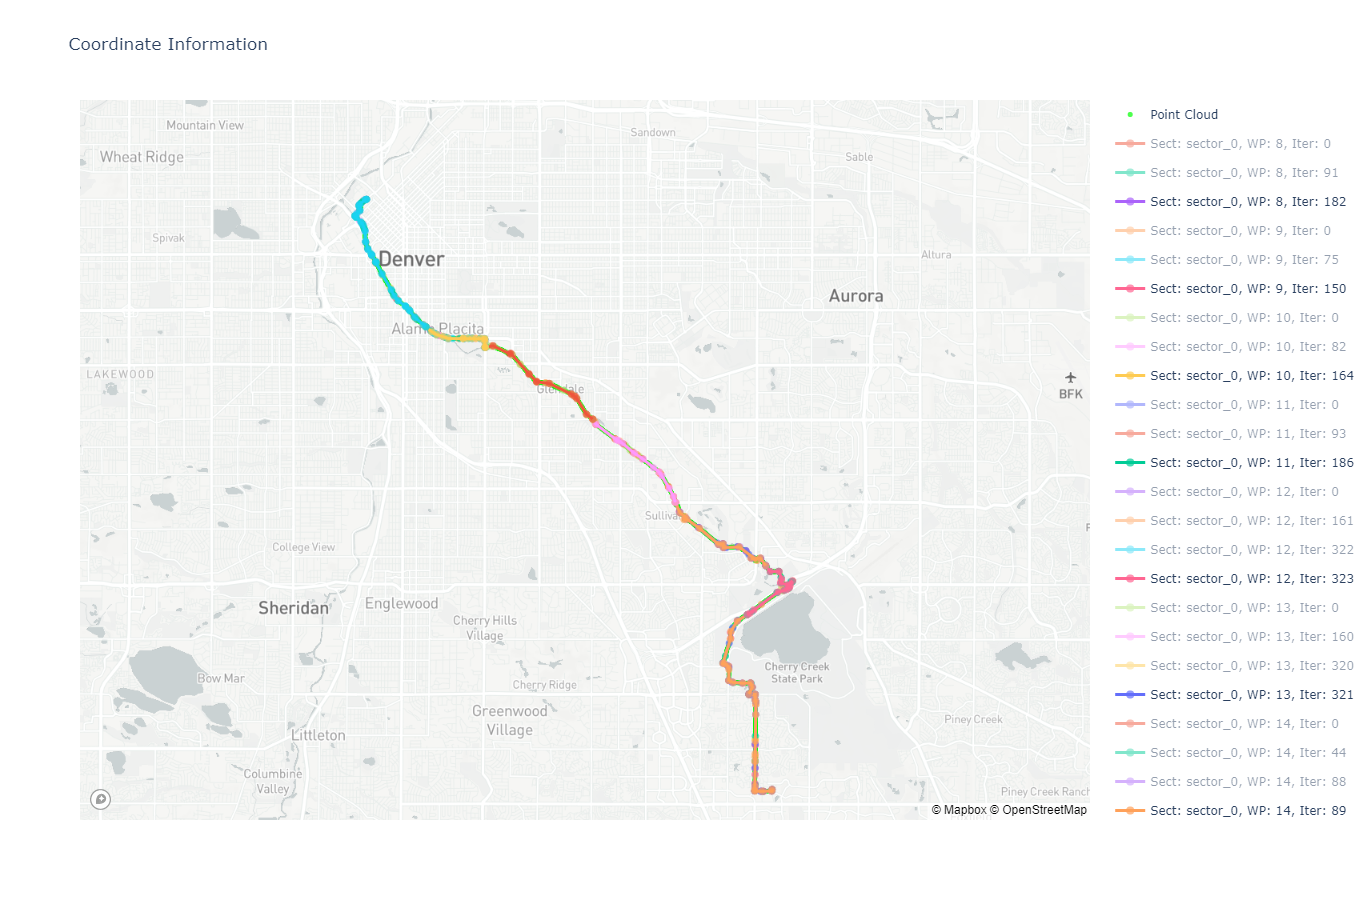

In [5]:
mapbox_access_token = open(".mapbox_token").read()

fig = go.Figure()

#  Add Points
sql_query = 'SELECT * FROM point_list ORDER BY timestamp'
full_points = pd.read_sql_query( sql_query, conn )
fig.add_trace(go.Scattermapbox(
        lat=full_points.loc[:,'latitude'],
        lon=full_points.loc[:,'longitude'],
        mode='markers',
        legendgroup='General Information',
        name='Point Cloud',
        marker=go.scattermapbox.Marker( size=5,
                                        color='rgb(0, 255, 0)',
                                        opacity=0.7 )
    ))

centroid = [full_points.loc[:,'latitude'].mean(),
            full_points.loc[:,'longitude'].mean()]
fig.update_layout(
    title='Coordinate Information',
    autosize=True,
    hovermode='closest',
    showlegend=True,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=vtx_list['Latitude'].mean(),
            lon=vtx_list['Longitude'].mean()
        ),
        pitch=0,
        zoom=11,
        style='light'
    ),
    height=900,
)

#  Get the list of sectors
sector_list = vtx_list['SectorId'].unique()
for sector_id in sector_list:
    
    # Get the list of entries only for this sector
    vtx_sector = vtx_list.loc[vtx_list['SectorId'] == sector_id]
    
    #  Get the list of waypoints for this sector
    waypoints = vtx_sector['NumWaypoints'].unique()
    minWP = np.min(waypoints)
    maxWP = np.max(waypoints)
    pts_per_group = 2
    
    for waypoint in range(minWP, maxWP+1):
        
        #  Get the list of points for this range
        vtx_wp = vtx_sector.loc[vtx_sector['NumWaypoints'] == waypoint]
        
        #  Get the list of waypoint sizes
        iterations = vtx_wp['Iteration'].unique()
        iter_size = int(iterations[-1]/pts_per_group)
        if len(iterations) > pts_per_group:
            iterations = iterations[0::iter_size]
        iterations = np.append( iterations, vtx_wp['Iteration'].max() )
        iterations = np.unique( iterations )
    
        #  Get the list of waypoints
        for iteration in iterations:
    
            cmap = mpl.cm.get_cmap('Spectral')

            #  Assign a color
            color = 0
            if len(iterations) > 0 or (iterations.max() - iterations.min()) < 0.1:
                color = cmap((iteration - iterations.min()) / (iterations.max() - iterations.min()))
    
            #  Add the trace
            vtx_iter = vtx_wp.loc[vtx_wp['Iteration'] == iteration]
            visible_flag='legendonly'
            if iteration == iterations[-1]:
                visible_flag=True
            fig.add_trace( go.Scattermapbox( lat=vtx_iter['Latitude'],
                                             lon=vtx_iter['Longitude'],
                                             mode='markers+lines',
                                             line=dict(width=3),
                                             name='Sect: {}, WP: {}, Iter: {}'.format(sector_id, waypoint, iteration),
                                             visible=visible_flag,
                                             marker=go.scattermapbox.Marker( size=8,
                                                                             opacity=0.7 )))

fig.show()

## Step 5: Construct Time-Lapse Image



In [6]:
#  Wipe out frame directory contents
#shutil.rmtree('./frames')
#os.makedirs('./frames')
if True:
    print('Skipping File Writes')
else:
    cmap = mpl.cm.get_cmap('Spectral')

    #  Get the list of sectors
    sector_list = vtx_list['SectorId'].unique()
    for sector_id in sector_list:

        cmap = mpl.cm.get_cmap('Spectral')

        # Get the list of entries only for this sector
        vtx_sector = vtx_list.loc[vtx_list['SectorId'] == sector_id]
    
         #  Get the list of waypoints for this sector
        waypoints = vtx_sector['NumWaypoints'].unique()
        minWP = np.min(waypoints)
        maxWP = np.max(waypoints)

        for waypoint in range(minWP, maxWP+1):
        
            #  Get the list of points for this range
            vtx_wp = vtx_sector.loc[vtx_sector['NumWaypoints'] == waypoint]
        
            #  Get the list of waypoint sizes
            iterations = vtx_wp['Iteration'].unique()

            cmap = mpl.cm.get_cmap('Spectral')
            for iteration in iterations:

                #  Assign a color
                color = 0
                if len(iterations) > 0 or (iterations.max() - iterations.min()) < 0.1:
                    color = cmap((iteration - iterations.min()) / (iterations.max() - iterations.min()))
    
                #  Add the trace
                vtx_iter = vtx_wp.loc[vtx_wp['Iteration'] == iteration]
        
                image_pathname = 'frames/{}_wp_{}_frame_'.format(sector_id,waypoint) + str(iteration).zfill(4) + '.png'
                if os.path.exists( image_pathname ):
                    continue
        
                fig2 = go.Figure()

                #  Add Points
                fig2.add_trace(go.Scattermapbox( lat=full_points.loc[:,'latitude'],
                                                 lon=full_points.loc[:,'longitude'],
                                                 mode='markers',
                                                 name='Point Cloud',
                                                 marker=go.scattermapbox.Marker( size=5,
                                                                                 color='rgb(0, 255, 0)',
                                                                                 opacity=0.7 )))
            
                #  Add Vertices for Iteration
                fig2.add_trace( go.Scattermapbox( lat=vtx_iter['Latitude'],
                                                  lon=vtx_iter['Longitude'],
                                                  mode='markers+lines',
                                                  line=dict(width=4),
                                                  name='Sect: {}, Iter: {}'.format(sector_id, iteration),
                                                  visible=visible_flag,
                                                  marker=go.scattermapbox.Marker( size=5,
                                                                                  color=color,
                                                                                  opacity=0.7 )))

                fig2.update_layout( title='Sector: {}, WP: {}, Iteration: {}'.format(sector_id,waypoint,iteration),
                                    autosize=True,
                                    hovermode='closest',
                                    showlegend=False,
                                    mapbox=dict( accesstoken=mapbox_access_token,
                                                 bearing=0,
                                                 center=dict( lat=vtx_wp['Latitude'].mean(),
                                                              lon=vtx_wp['Longitude'].mean() ),
                                                 pitch=0,
                                                 zoom=13,
                                                 style='light' ),
                                    height=900,
                                  )
                print('Writing: ' + image_pathname)
                fig2.write_image( image_pathname, engine="kaleido" )

Skipping File Writes


## Step 6 : Selecting "Best-Fit" Track

From the results, we need to select the "best-fit" track.  For each segment, we need to select the best set of waypoints from the previous step.

For each sector, we need to select which waypoint-count and iteration we need. 
For the "last" iteration automatically, use -1.

In [7]:
sector_list = vtx_list['SectorId'].unique()
sector_widget = {}

for sector_id in sector_list:
    
    sector_widget[sector_id] = { 'wayp': widgets.IntText( value=8, min=-1, step=1, 
                                                          description='Waypoints'),
                                 'iter': widgets.IntText( value=-1, min=-1, step=1, 
                                                          description='Iteration') }
    
    #  Show widget
    display(widgets.HBox( [widgets.Label(value=sector_id + ' '),
                           sector_widget[sector_id]['wayp'],
                           sector_widget[sector_id]['iter'] ] ))
run_button = widgets.Button( description='Create Master Route',
                             button_style='', # 'success', 'info', 'warning', 'danger' or ''
                             tooltip='Click button to generate route',
                             icon='check',
                             layout=widgets.Layout(width='25%'))
output = widgets.Output()
display(run_button,output)

master_route = pd.DataFrame( columns=vtx_list.columns )

def on_button_clicked(master_route, button):
    with output:
        
        #  Iterate over sectors, getting desired settings
        for sector_id in sector_list:
            
            #  Get the settings
            waypoints = sector_widget[sector_id]['wayp'].value
            iteration = sector_widget[sector_id]['iter'].value
            
            # Get the list of entries only for this sector
            vtx_sector = vtx_list.loc[ (vtx_list['SectorId'] == sector_id) & (vtx_list['NumWaypoints'] == waypoints) ]
            
            #  Error Check
            if len(vtx_sector) <= 0:
                raise Exception('Invalid Number of Waypoints Selected: {}'.format(waypoints))
            
            #  Get the iteration range
            iter_val = vtx_sector['Iteration'].unique()[iteration]
            
            #  Get the coordintes
            vtx_iter = vtx_sector.loc[vtx_sector['Iteration'] == iter_val]
            master_route = pd.concat([master_route, vtx_iter])
        
        display(master_route)

bound_click_method = partial(on_button_clicked, master_route)
run_button.on_click(bound_click_method)


Button(description='Create Master Route', icon='check', layout=Layout(width='25%'), style=ButtonStyle(), toolt…

Output()